In [1]:
# 브런치 스토리 자취 검색 크롤링
# ------------------2024-08-06
# -----------------made by 서연

In [17]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pyperclip
import time
from selenium.webdriver.common.action_chains import ActionChains
from tqdm import tqdm

In [18]:
driver = webdriver.Chrome()

In [19]:
driver.get("https://brunch.co.kr/search?q=%EC%9E%90%EC%B7%A8")

In [20]:
soup  = bs(driver.page_source, 'lxml')

In [21]:
height = driver.execute_script("return document.body.scrollHeight")

In [22]:
#무한 스크롤링
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break

    last_height = new_height

In [23]:
soup  = bs(driver.page_source, 'lxml')

In [24]:
url = soup.select('a', class_='link_post #post_list')

In [25]:
url_list = []
for i in url:
    url_list.append("https://brunch.co.kr" + i['href'])

In [26]:
len(url_list)

768

In [27]:
# 링크를 DataFrame으로 저장
df = pd.DataFrame(url_list, columns=['URL'])

# 'https://brunch.co.kr/@'로 시작하는 URL만 필터링
df_filtered = df[df['URL'].str.startswith('https://brunch.co.kr/@@')]

In [28]:
df_filtered

,URL
12,https://brunch.co.kr/@@cUM5/160
13,https://brunch.co.kr/@@2vLY/858
14,https://brunch.co.kr/@@6PPn/140
15,https://brunch.co.kr/@@1mja/7
16,https://brunch.co.kr/@@bAeK/231
...,...
726,https://brunch.co.kr/@@fO3c/40
727,https://brunch.co.kr/@@ffY9/35
728,https://brunch.co.kr/@@eTui/173
729,https://brunch.co.kr/@@fdyL/107


In [41]:
# 결과를 저장할 리스트
title_list = []
contents_list = []

# 데이터프레임에서 URL 추출
urls = df_filtered['URL'].tolist()

# 각 URL을 순회하여 제목과 내용 추출
for url in tqdm(urls):
    driver.get(url)
    time.sleep(0.5)  # 페이지 로드 대기

    try:
        # 제목 추출
        title_element = driver.find_element(By.CSS_SELECTOR, "h1.cover_title")
        title = title_element.text
        title_list.append(title)
        
        # 내용 추출
        soup = bs(driver.page_source, 'lxml')
        contents_element = soup.select_one('div.wrap_item.item_type_img')
        if contents_element:
            contents = contents_element.get_text(separator='\n', strip=True)
            contents_list.append(contents)
        else:
            contents_element = soup.select_one('div.wrap_body.text_align_left.finish_txt')
            if contents_element:
                contents = contents_element.get_text(separator='\n', strip=True)
                contents_list.append(contents)
            else:
                contents = '내용 없음'
                contents_list.append(contents)

    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        title_list.append('제목 없음')
        contents_list.append('내용 없음')

100%|██████████| 719/719 [14:48<00:00,  1.24s/it]


In [42]:
len(contents_list)

719

In [43]:
brunchStory = pd.DataFrame(contents_list, columns=['contents'])

In [45]:
brunchStory

,contents
0,
1,
2,오랜만에 만들어 본 장조림 덮밥
3,"스무 살이 되어 자취를 시작했다. 나의 공간에서 홀로, 하루를 꾸리는 중이다. 생활..."
4,'혼자 사는 남자라고 하면 생각나는 것들이 있지. 왠지 끼니도 잘\n챙기\n지 못할...
...,...
714,회사가\n직장인의\n자아실현의\n장이냐는\n물음에\n거짓말이라고\n속지 말라는\n말...
715,우리 동네에는 특별한 지하철이 운행된다. 서울 중심가에서 두 시간은 족히 떨어진 외...
716,임 소장과 국장에게서 전화가 걸려 오는 횟수가 잦아졌다. 둘 다 선유와 호진의 결정...
717,"나에게 집은 잠자는 곳 그 이상, 그 이하도 아니었다.\n학창 시절 학교 앞에서 자..."


In [46]:
from konlpy.tag import Okt
okt = Okt()

In [71]:
stopwords = ['있다', '되다', '하다', '나', '는', '은', '이', '가', '을', '를', '에', '에서', 
             '에게', '한테', '과', '와', '아', '랑', '으로', '로', '께서', '이나', '이라', '이야', 
             '인가', '이야말로', '그리고', '그런데', '그래서', '그래도', '그러나', '그럼에도', '그러면', 
             '그러니까', '그러므로', '그러니까', '그렇게', '그렇지만', '그렇다면', '아니면', '아니라', 
             '그런', '이런', '그렇지', '그래', '저런', '이러한', '그러한', '저러한', '어떤', '이따', 
             '이래', '이렇게', '저렇게', '그따', '그래서', '아무', '전부', '가지', '갖고', '몇', 
             '무슨', '어느', '몇몇', '어떤', '어떻게', '어떤', '아무', '나', '우리', '당신', '자기', 
             '그녀', '저희', '하다', '되다', '않다', '없다', '있다', '되어다', '하고', '그러면', 
             '그래서', '이렇게', '저렇게', '요즘', '그것', '이것', '저것', '있다고', '그렇지만', '그래도',
            '수', '안녕하세요', '그', '내', '이다', '안녕하다', '아니다', '같다', '거', '것', '음식', '음식물', '보다',
            '오늘', '혹시', '안', '그렇다', '때', '어떻다']

In [83]:
def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun'] if word not in stopwords ]
    return words

In [84]:
cleaned_contents_list = []

for content in contents_list:
    # 공백 및 줄바꿈 제거
    cleaned_content = content.strip()  # 양쪽 공백 제거
    
    # 연속된 공백을 단일 공백으로 변환
    cleaned_content = ' '.join(cleaned_content.split())
    
    cleaned_contents_list.append(cleaned_content)

In [85]:
# 추출된 단어들을 저장할 리스트
extracted_words_list = []

# cleaned_contents_list에 있는 각 텍스트에 대해 okt_pos_tagging 함수 호출하여 추출된 단어들을 리스트에 저장
for text in cleaned_contents_list:
    extracted_words = okt_pos_tagging(text)
    extracted_words_list.append(extracted_words)

# 저장된 추출된 단어들 리스트 출력
for idx, extracted_words in enumerate(extracted_words_list, start=1):
    print(f"추출된 단어들: {extracted_words}")
    print()

추출된 단어들: []

추출된 단어들: []

추출된 단어들: ['만', '장조림', '밥']

추출된 단어들: ['스무', '살이', '자취', '시작', '공간', '홀로', '하루', '중이', '생활', '자립', '마음', '순천', '살이', '해', '더', '경험', '스스로', '얼마나', '체감', '기억', '다섯', '살', '기숙사', '생활', '편이', '아침', '칼', '눈', '저녁', '잠', '생활', '습', '밥', '청소', '경험', '룸메이트', '스트레스', '스트레스', '경험', '지지', '웃음', '경험', '옷', '쓰레기', '방과', '날', '방도', '마음', '모든', '경험', '지금', '일상', '아주', '양분', '홀로', '일상', '스스로', '정인지', '기회', '탕', '장', '보아', '집', '오니', '입맛', '재료', '방치', '인간', '화장실', '청소', '부엌', '청소', '기분', '인간', '소리', '타격', '지난', '삶', '머리카락', '하나', '바닥', '집', '듯이', '청소', '인간', '창밖', '앞집', '사람', '눈', '눈', '창밖', '풍경', '인간', '침대', '위', '시간', '공복', '상태', '일', '끝', '끝내', '잠', '인간', '동안', '본가', '하루', '못', '집', '밤', '인간', '모습', '이십', '주변인', '꼭', '대화', '주제가', '하나', '먹이', '생활', '일', '돈', '시간', '품', '이야기', '청소년기', '가득', '준', '어른', '전', '하루하루', '몸', '마음', '지갑', '스스로', '연습', '갓난아기', '노인', '삶', '마무리', '인간', '자신', '인지', '인지', '평생', '속', '지금', '일상', '지탱', '무언가', '일', '스스로', '일과', '집', '식물', '거북이', '치치', '물', '

In [92]:
data = {"내용" : cleaned_contents_list, "추출된 단어" : extracted_words_list}

In [93]:
brunchStory_df = pd.DataFrame(data)

In [94]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

In [98]:
count_list = []

for words in extracted_words_list:
    count  = Counter(words)
    count.most_common(200) 
    count_list.append(count)

In [99]:
# 모든 Counter 객체를 합치기
total_counter = Counter()
for counter in count_list:
    total_counter += counter

<function matplotlib.pyplot.show(close=None, block=None)>

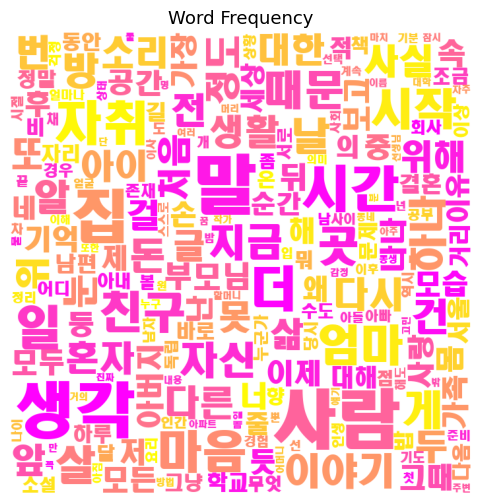

In [100]:
from wordcloud import WordCloud

# 한글 폰트 경로 설정
font_path = "'C:\Windows\Fonts\HMKMRHD.TTF"

# WordCloud 객체 생성
wordcloud = WordCloud(font_path=font_path,
                      width=700, 
                      height=700, 
                      background_color='white',
                      colormap='spring',
                      random_state=1).generate_from_frequencies(total_counter)

# 시각화
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Frequency", size = 13) 
plt.show